# Behaviour Scoring Scorecard Workflow

*Note: This notebook is an alternative to [this article](https://rpubs.com/ranydc/math_scorecard) for Behaviour Scorecard with the Python programming language.

# Problem Statement 

Dari input data behaviour nasabah yang sudah dan sedang mengambil produk kredit di suatu bank, kita ingin mendapatkan analisis skor resiko untuk nasabah tersebut dan ambang batas (cutoff) yang digunakan oleh bank untuk menentukan apakah aplikasi kredit disetujui atau ditolak berdasarkan tingkat kelayakan kredit pemohon.

# Read Data

In [1]:
import pandas as pd # data analysis
import numpy as np
import math
import scorecardpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.cbook import boxplot_stats # boxplot value extraction

%matplotlib inline

In [2]:
data = pd.read_excel("data_input/credit_taiwan.xlsx")
data.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,gb_flag
0,1,20000,2,3,2,39,0,0,2,2,...,20906.0,20289.0,20407.0,4000,1000,4750,0,600,0,1
1,2,100000,1,3,2,49,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,3,80000,2,1,2,26,2,0,0,2,...,41577.0,41595.0,43264.0,2000,3000,2000,1000,2500,1000,1
3,4,280000,2,2,1,31,0,0,0,2,...,68277.0,72042.0,65921.0,6000,6000,0,4800,0,2226,0
4,5,130000,1,2,1,53,2,2,2,0,...,96995.0,100086.0,92344.0,17100,17,4000,5000,4000,4000,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30952 entries, 0 to 30951
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         30952 non-null  int64  
 1   limit_bal  30952 non-null  int64  
 2   sex        30952 non-null  int64  
 3   education  30952 non-null  int64  
 4   marriage   30952 non-null  int64  
 5   age        30952 non-null  int64  
 6   pay_1      30952 non-null  int64  
 7   pay_2      30952 non-null  int64  
 8   pay_3      30952 non-null  int64  
 9   pay_4      30952 non-null  int64  
 10  pay_5      30952 non-null  int64  
 11  pay_6      30952 non-null  int64  
 12  bill_amt1  30952 non-null  float64
 13  bill_amt2  30952 non-null  float64
 14  bill_amt3  30952 non-null  float64
 15  bill_amt4  30952 non-null  float64
 16  bill_amt5  30952 non-null  float64
 17  bill_amt6  30952 non-null  float64
 18  pay_amt1   30952 non-null  int64  
 19  pay_amt2   30952 non-null  int64  
 20  pay_am

Deskripsi data:

- `id` = id debitur
- `limit_bal` = Besaran kredit limit yang diberikan dalam dolar New Taiwan
- `sex` = jenis kelamin
    + 1 = laki-laki
    + 2 = perempuan
- `education` = Pendidikan terakhir
    + 1 = pascasarjana (S2 & S3)
    + 2 = universitas (S1)
    + 3 = high school (SMA)
    + 4 = lain-lain
- `marriage` = Status pernikahan
    + 1 = menikah
    + 2 = lajang
    + 3 = lainnya
- `age` = Usia dalam tahun
- `pay_*` = Status pembayaran dalam bulan April (1) - September (6).
    + 0 = pembayaran tepat waktu
    + 1 = keterlambatan pembayaran satu bulan
    + 2 = keterlambatan pembayaran dua bulan
    + …
    + 8 = keterlambatan pembayaran delapan bulan atau lebih
- `bill_amt*` = Jumlah tagihan pada bulan April (1) - September (6) dalam dolar NT
- `pay_amt*` = Jumlah pembayaran/pengeluaran sebelumnya pada bulan April (1) - September(6) dalam dolar NT
- `gb_flag` = Flagging pembayaran default (gagal bayar) pada bulan berikutnya
    + 1 = default
    + 0 = not default

Fitur atau informasi dari data yang akan kita gunakan berupa perilaku dari customer yang berasal dari satu company saja sehingga, tipe scorecardnya berupa internal [behaviour scorecard](https://www.openriskmanual.org/wiki/Behavioral_Scoring).

# Data Cleansing 

In [4]:
data.head(3)

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,gb_flag
0,1,20000,2,3,2,39,0,0,2,2,...,20906.0,20289.0,20407.0,4000,1000,4750,0,600,0,1
1,2,100000,1,3,2,49,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,3,80000,2,1,2,26,2,0,0,2,...,41577.0,41595.0,43264.0,2000,3000,2000,1000,2500,1000,1


In [5]:
# drop kolom 
data.drop(columns='id', inplace=True)

In [6]:
# kolom dengan tipe data kategorikal
cat_features = ['sex', 'education', 'marriage']
# mengubah tipe data
data[cat_features] = data[cat_features].astype('category')
# menampilkan tipe data
data.dtypes

limit_bal       int64
sex          category
education    category
marriage     category
age             int64
pay_1           int64
pay_2           int64
pay_3           int64
pay_4           int64
pay_5           int64
pay_6           int64
bill_amt1     float64
bill_amt2     float64
bill_amt3     float64
bill_amt4     float64
bill_amt5     float64
bill_amt6     float64
pay_amt1        int64
pay_amt2        int64
pay_amt3        int64
pay_amt4        int64
pay_amt5        int64
pay_amt6        int64
gb_flag         int64
dtype: object

In [7]:
# cek missing value
data.isna().sum()

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
gb_flag      0
dtype: int64

> Tidak ada missing value pada data kita.

In [8]:
# mapping number value with string categories to make interpretation easier
data['marriage'] = data['marriage'].map({0: 'unknown', 1: 'married', 2: 'single', 3: 'others'})
data['sex'] = data['sex'].map({1: 'male', 2: 'female'})
data['education'] = data['education'].map({1: 'graduate school', 
                                           2: 'university', 
                                           3: 'high school', 
                                           4: 'others',
                                           5: 'unknown',
                                           6: 'unknown'})

In [9]:
# sanity check
print(data.marriage.cat.categories)
print(data.sex.cat.categories)
print(data.education.cat.categories)

Index(['unknown', 'married', 'single', 'others'], dtype='object')
Index(['male', 'female'], dtype='object')
Index(['graduate school', 'university', 'high school', 'others'], dtype='object')


In [10]:
data.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,gb_flag
0,20000,female,high school,single,39,0,0,2,2,3,...,20906.0,20289.0,20407.0,4000,1000,4750,0,600,0,1
1,100000,male,high school,single,49,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,80000,female,graduate school,single,26,2,0,0,2,2,...,41577.0,41595.0,43264.0,2000,3000,2000,1000,2500,1000,1
3,280000,female,university,married,31,0,0,0,2,2,...,68277.0,72042.0,65921.0,6000,6000,0,4800,0,2226,0
4,130000,male,university,married,53,2,2,2,0,0,...,96995.0,100086.0,92344.0,17100,17,4000,5000,4000,4000,1


## Cek distribusi kelas target 

Mengutip Siddiqi, Naeem, 

> *The quantity of data needed varies, but in general, it should fulfill the requirements of statistical significance and randomness. Exact numbers are not critical. For behavior scorecards, there should be approximately 2,000 “bad” from a group of accounts that were current at a given point in time, or at a certain delinquency status for collections scoring. A further 2,000 declined applications may also be required for application scorecards where reject inference is to be performed. The organization’s loss/delinquency/claims, or other performance reports, and volume of applications should provide an initial idea of whether this target can be met. Typically, it is more difficult to find enough “bad” accounts than “good” ones.*

In [11]:
# tabel proporsi data target
data['gb_flag'].value_counts()

gb_flag
0    16685
1    14267
Name: count, dtype: int64

In [12]:
# proporsi data target dalam bentuk persentase
pd.crosstab(index=data['gb_flag'],
            columns='percentage',
            values= data['gb_flag'],
            aggfunc='count',
            normalize=True).mul(100).round(2)

col_0,percentage
gb_flag,
0,53.91
1,46.09


> Data cukup seimbang.

- Rule of Thumb proporsi data tidak seimbang 

| Degree of Imbalance     | Proportion of Minority Class |
| ----------- | ----------- |
| Mild      | 20-40% of the dataset      |
| Moderate   | 1-20% of the dataset        |
| Extreme   | <1% of the dataset         |

- Treatment: upsampling, downsampling, SMOTE, proportional sampling. 
- Jika proporsi antar label di data sampel mewakili proporsi asli populasi, kita dapat menggunakan proportional sampling. Ketika masuk di bagian pemodelan, gunakan metode offset atau sampling weights.

## Train Test Splitting

In [13]:
# breaking dt into train and test
train, test = sc.split_df(data, 'gb_flag').values()

In [14]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (21667, 24)
test shape: (9285, 24)


# Exploratory Data Analysis 

## Descriptive Statistics 

In [15]:
# fitur numerik
train.describe().T

,count,mean,std,min,25%,50%,75%,max
limit_bal,21667.0,146594.422855,125590.363193,10000.0,50000.0,100000.0,210000.0,800000.0
age,21667.0,35.272304,9.372659,21.0,28.0,34.0,42.0,73.0
pay_1,21667.0,0.557299,0.860897,0.0,0.0,0.0,1.0,8.0
pay_2,21667.0,0.636636,1.031271,0.0,0.0,0.0,2.0,7.0
pay_3,21667.0,0.567130,1.007887,0.0,0.0,0.0,2.0,8.0
pay_4,21667.0,0.464716,0.974373,0.0,0.0,0.0,0.0,8.0
pay_5,21667.0,0.410717,0.939213,0.0,0.0,0.0,0.0,8.0
pay_6,21667.0,0.406609,0.921746,0.0,0.0,0.0,0.0,8.0
bill_amt1,21667.0,50939.933378,70687.218018,0.0,6300.0,25264.0,65237.0,746814.0
bill_amt2,21667.0,49648.430009,68692.462781,0.0,6218.0,24837.0,63099.0,581775.0


## Korelasi 

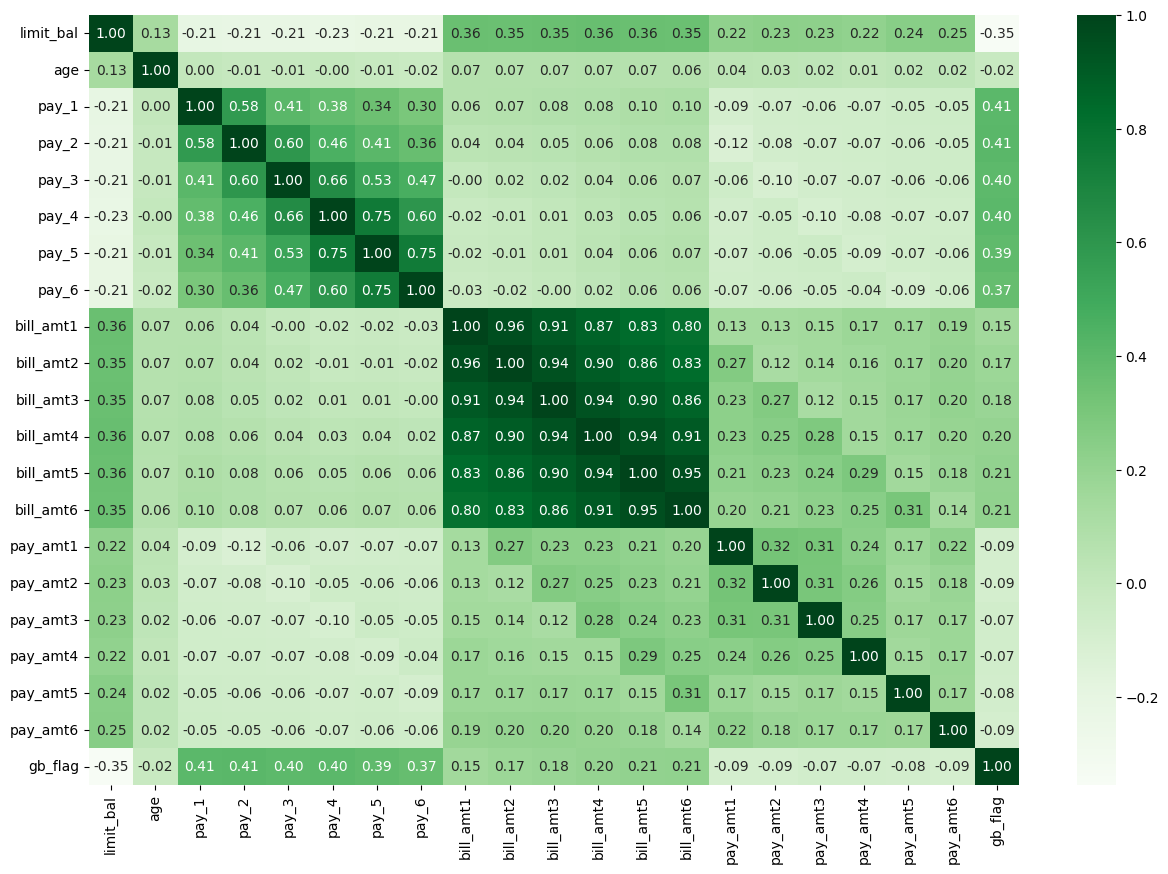

In [16]:
plt.figure(figsize = (15,10))

fig = sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="Greens", fmt='.2f')

> Tidak ada indikasi multicolinearity antar prediktor dan tidak ada korelasi yang cukup kuat antar prediktor dengan target (gb_flag)

## Mengecek Distribusi Variabel Prediktor 

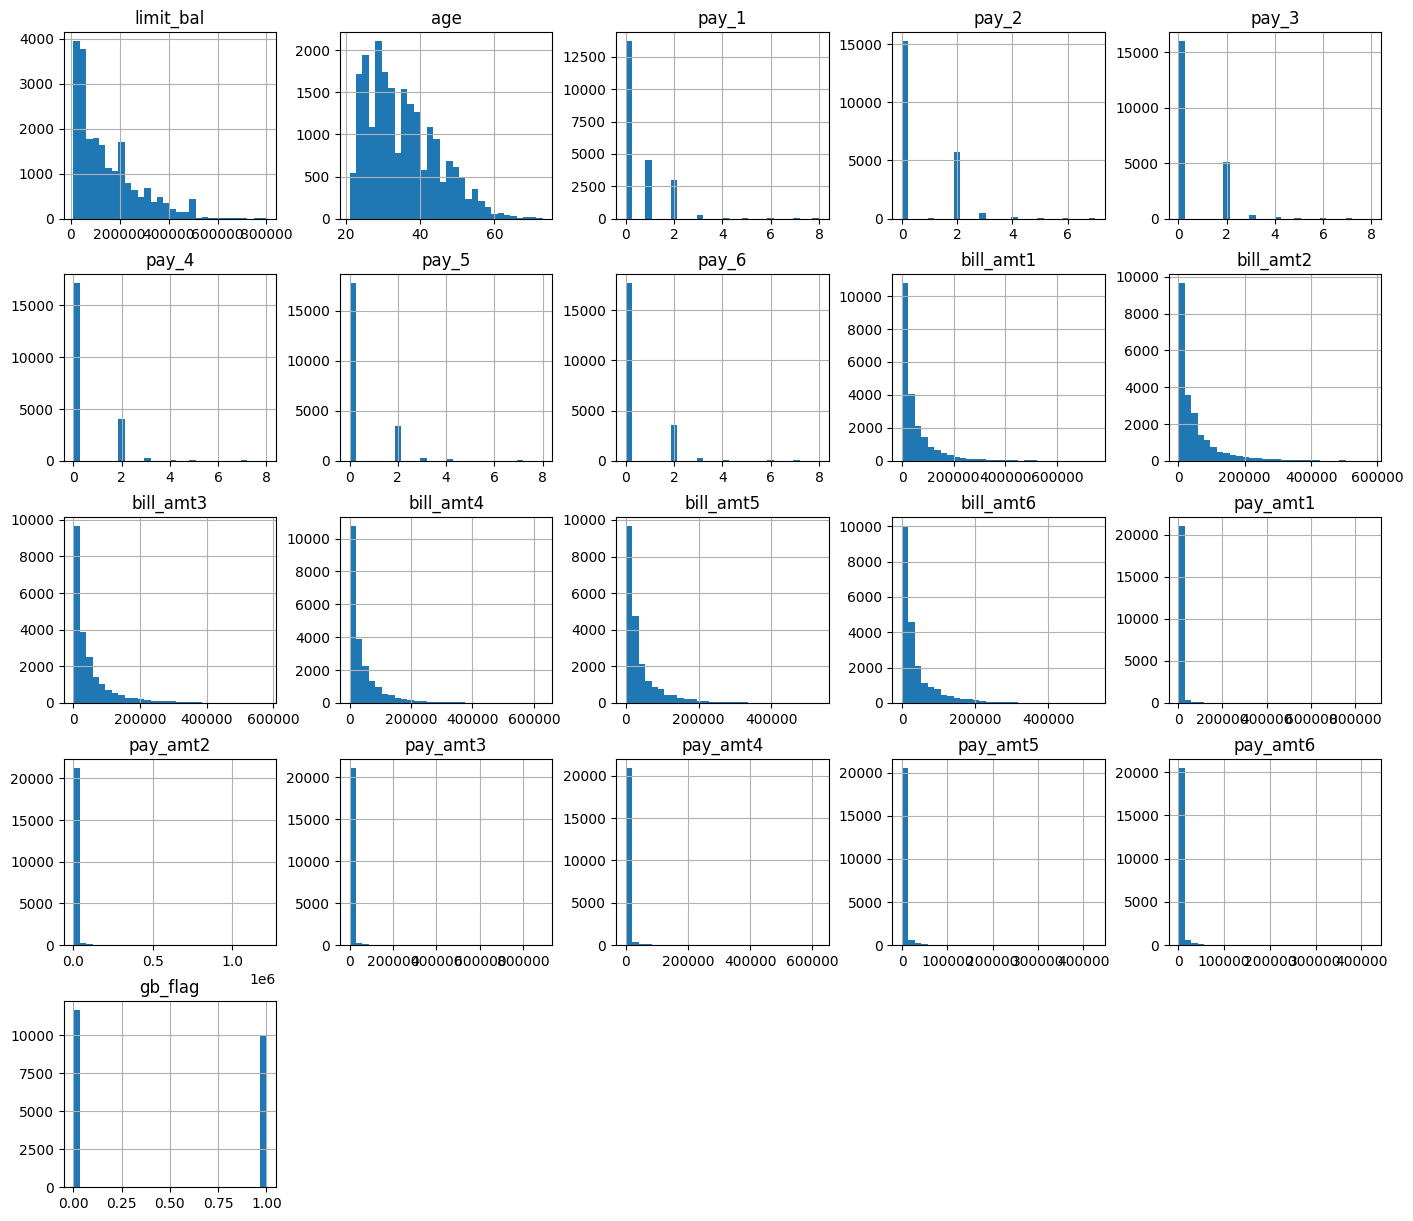

In [17]:
train.hist(bins=30, figsize=(17, 15))
plt.show()

> Tiap fitur/variable cenderung mempunyai distribusi yang skewed ke kanan. 

### Berdasarkan `limit_bal` 

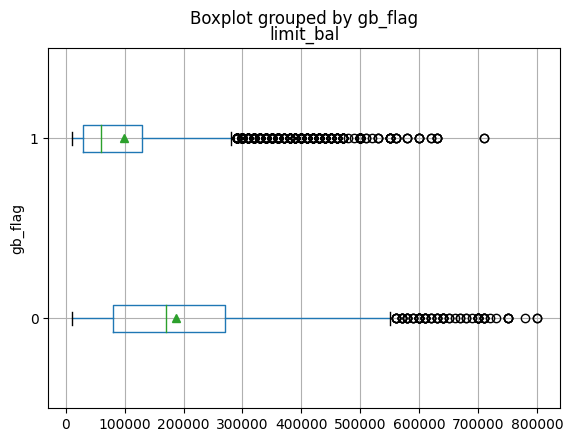

In [18]:
train.boxplot(column='limit_bal', by='gb_flag', vert=False, showmeans=True);

In [19]:
train["limit_bal"].groupby(train["gb_flag"]).describe()

,count,mean,std,min,25%,50%,75%,max
gb_flag,,,,,,,,
0,11680.0,187780.479452,134219.156023,10000.0,80000.0,170000.0,270000.0,800000.0
1,9987.0,98426.490438,94064.724335,10000.0,30000.0,60000.0,130000.0,710000.0


> - Besaran maksimal kredit limit default(gagal bayar/1) lebih kecil dibanding non default.
> - Distribusi jumlah kredit limit non default lebih tersebar dibanding default.
> - Baik default dan non default punya outliers atas.

### Berdasarkan `age`

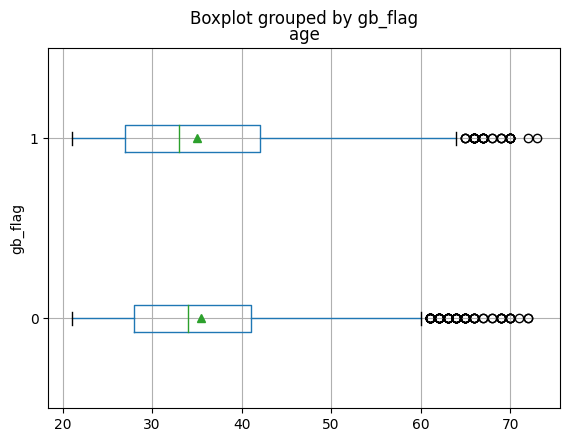

In [20]:
train.boxplot(column='age', by='gb_flag', vert=False, showmeans=True);

In [21]:
boxplot_stats(train.loc[train.gb_flag.eq(1), "age"])

[{'mean': 35.06268148593171,
  'iqr': 15.0,
  'cilo': 32.764346775590006,
  'cihi': 33.235653224409994,
  'whishi': 64,
  'whislo': 21,
  'fliers': array([67, 67, 65, 70, 66, 67, 68, 67, 67, 67, 66, 69, 66, 66, 65, 66, 66,
         68, 66, 70, 66, 66, 72, 66, 69, 70, 66, 67, 70, 66, 70, 67, 66, 69,
         66, 70, 66, 73, 70, 65, 70]),
  'q1': 27.0,
  'med': 33.0,
  'q3': 42.0}]

In [22]:
boxplot_stats(train.loc[train.gb_flag.eq(0), "age"])

[{'mean': 35.45154109589041,
  'iqr': 13.0,
  'cilo': 33.81114800224834,
  'cihi': 34.18885199775166,
  'whishi': 60,
  'whislo': 21,
  'fliers': array([61, 65, 64, 72, 64, 64, 69, 69, 62, 70, 61, 64, 63, 61, 66, 61, 61,
         65, 66, 63, 68, 72, 61, 63, 61, 66, 63, 64, 65, 71, 61, 69, 67, 61,
         61, 63, 65, 63, 62, 63, 62, 65, 62, 62, 61, 62, 62, 70, 62, 64, 62,
         69, 63, 67, 62, 70, 64, 61, 64, 61, 61, 61, 62, 65, 66, 63, 64, 61,
         70, 66, 61, 61, 69, 68, 64, 63, 61, 65, 65, 64, 62, 63, 61, 62, 69,
         65, 61, 65, 61, 70, 64, 62, 64, 66, 65]),
  'q1': 28.0,
  'med': 34.0,
  'q3': 41.0}]

> - Baik debitur default maupun non default usianya 50% berada di antara 27 hingga 42 tahun.
> - Outlier atas selalu ada di debitur default dan non default.

### Berdasarkan `education` 

In [23]:
train["education"].groupby(train["gb_flag"]).describe()

,count,unique,top,freq
gb_flag,,,,
0,11680,4,university,5211
1,9987,4,university,5363


In [24]:
train["education"].groupby(train["gb_flag"]).count()

gb_flag
0    11680
1     9987
Name: education, dtype: int64

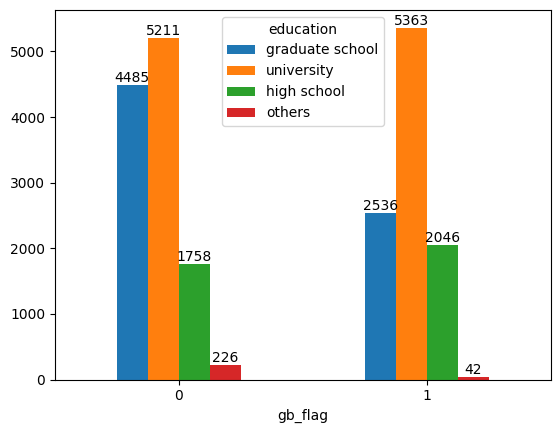

In [25]:
ax = train.groupby(['gb_flag', 'education'])['pay_1'].count().unstack().plot(kind='bar', rot=0);
#menampilkan label di bar chart
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3]);

> - Pendidikan terakhir paling banyak di debitur default dan non default adalah universitas. 
> - Jumlah debitur non default dengan pendidikan terakhir adalah graduate school/pasca sarjana lebih banyak hampir 2 kali lipat dibanding debitur default (gagal bayar)

# Initial Characteristic Analysis 

## Weight of Evidence (WoE) 

Pembentukan WOE bertujuan melakukan binning / kategorisasi seluruh variabel prediktor yang ada pada data, kemudian menghitung kekuatan masing-masing hasil kategori dalam memisahkan kelas positif dan kelas negatif. 

Hal ini penting karena:

- Membuat data lebih mudah dianalisis karena memisahkan beberapa nilai outlier, missing, dan kategori dengan frekuensi rendah.
- Proses characteristic binning ini membantu user memahami resiko behaviour debitur.
- Dependensi yang non linear akan bisa dimodelkan dengan model linear  $\rightarrow$ menyederhanakan model
- Memudahkan pembentukan scorecard

Formula WOE (Siddiqi, Naeem):

$$
log(\frac{Distr_{Good}}{Distr_{Bad}})
$$

Keterangan:

- $Distr_{Good}$ : proporsi target debitur good pada kategori bin
- $Distr_{Bad}$ : proporsi target debitur bad pada kategori bin

WoE mengukur dalam satuan log of odds. Nilai **WoE negatif** menunjukkan bahwa banyak sebaran kelas negatif pada kelompok tersebut dibanding kelas positif -> kekuatannya negatif. Begitupula sebaliknya.

Gunakan fungsi `woebin()`, dengan parameter:

- `dt` : data frame train
- `y` : nama variabel y pada data
- `positive`: kelas positive (debitur bad/1)

> - *Menetapkan label 1 (debitur bad) sebagai kelas positif untuk menyesuaikan rumus pada method `woebin()` dan memudahkan interpretasi.*
> - Biasanya, kelas positive adalah kelas/label yang ingin kita amati atau mempunyai bobot lebih banyak dibanding kelas lain. Dalam hal pembuatan scorecard, kelas debitur bad lebih diperhatikan.

Secara default, metode binning pada method `woebin()` menggunakan metode tree. Metode lainnya:

- freq $\rightarrow$ akan menghasilkan proporsi nilai yang cenderung sama antara binningnya
- width $\rightarrow$ akan menghasilkan binning yang secara rentang akan mirip antara satu dengan yang lain.

Minimum proporsi yang diberikan untuk menghasilkan satu binning adalah di angka 0.05 (default) $\rightarrow$ set manual (0.01 sampai 0.2)

In [26]:
# woe binning ------
bins = sc.woebin(dt=train, 
                 y="gb_flag",
                 positive=1)

[INFO] creating woe binning ...


In [27]:
bins['pay_3']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,pay_3,"[-inf,2.0)",15996,0.738266,10554,5442,0.340210,-0.505765,0.181411,0.738076,2.0,False
1,pay_3,"[2.0,inf)",5671,0.261734,1126,4545,0.801446,1.551950,0.556665,0.738076,inf,False


In [28]:
bins['education']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,education,graduate school,7021,0.324041,4485,2536,0.361202,-0.413557,0.053787,0.078769,graduate school,False
1,education,university,10574,0.488023,5211,5363,0.507187,0.185345,0.016839,0.078769,university,False
2,education,"high school%,%others",4072,0.187936,1984,2088,0.512770,0.207685,0.008143,0.078769,"high school%,%others",False


Output hasil `woebin()` berupa dictionary dengan key berupa nama variabel dan value berupa dataframe yang berisi:

- `variable` : nama variabel
- `bin` : hasil binning kategori
- `count` : jumlah data pada masing-masing bin
- `count_distr` : distribusi masing-masing bin/total data
- `good` : banyaknya kelas positif pada bin (default)
- `bad` : banyaknya kelas negatif pada bin
- `badprob` : bad/count masing-masing bin
- `woe` : nilai woe untuk bin tersebut
- `bin_iv`: nilai Information Value untuk bin tersebut
- `total_iv`: nilai total Information Value untuk satu variabel tersebut
- `breaks`: nilai atau kategori paling akhir dari binning tersebut
- `is_special_values`: 

Contoh interpretasi dari output `bins['pay_3']`:

- variable pay_3 dibagi menjadi dua bins, bin `[-inf,2.0)` dan bin `[2.0,inf)`.
- pada bin `[-inf,2.0)` ada total observasi sebanyak 15996 atau 0.74 dari semua variable `pay_3`
- semua bins mempunyai kelas positive dan negative.

In [29]:
bins['pay_2']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,pay_2,"[-inf,2.0)",15276,0.705035,10262,5014,0.328227,-0.55962,0.210721,0.742163,2.0,False
1,pay_2,"[2.0,inf)",6391,0.294965,1418,4973,0.778125,1.41137,0.531442,0.742163,inf,False


In [30]:
# contoh perhitungan manual 
# binning [-inf,2)
distribution_good_1 = bins['pay_2']['good'][0]/bins['pay_2']['good'].sum()
distribution_bad_1 = bins['pay_2']['bad'][0]/bins['pay_2']['bad'].sum()

# The default woe in woebin() method is defined as ln(Distr_Bad_i/Distr_Good_i).
print('woe binning pay_2 [-inf,2):', math.log(distribution_bad_1/distribution_good_1))

woe binning pay_2 [-inf,2): -0.5596200226445879


In [31]:
# contoh perhitungan manual 
# binning [2, inf)
distribution_good_2 = bins['pay_2']['good'][1]/bins['pay_2']['good'].sum()
distribution_bad_2 = bins['pay_2']['bad'][1]/bins['pay_2']['bad'].sum()

# The default woe in woebin() method is defined as ln(Distr_Bad_i/Distr_Good_i).
print('woe binning pay_2 [2, inf):', math.log(distribution_bad_2/distribution_good_2))

woe binning pay_2 [2, inf): 1.4113695817617493


> - Bin dengan nilai pay_2 = [-Inf,2) sebesar -0.5559102 menunjukkan sebaran kelas negatif/good/non default lebih banyak dibanding sebaran kelas positif/bad/gagal bayar pada kategori tersebut.
> - Bin dengan nilai pay_2 = [2, Inf) sebesar 1.40745 menunjukkan sebaran kelas gagal bayar/bad lebih banyak dibanding sebaran kelas non default/good pada kategori tersebut.

### Mengubah dataframe ke dalam WOE

Setelah kita mengetahui nilai WOE dan binning pada data, nilai data/values di data train maupun test kita perlu dikonversi ke nilai WOE sesuai kategori/bins yang sudah dihitung.


kita dapat menggunakan method `woebin_ply()`, dengan parameter:

- `dt`: dataframe yang akan ditransformasi $\rightarrow$ data train
- `bins`: informasi binning yang dihasilkan dari woebin

In [32]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [33]:
train_woe.head(2)

,gb_flag,age_woe,bill_amt5_woe,pay_amt3_woe,bill_amt1_woe,marriage_woe,pay_1_woe,pay_amt5_woe,pay_2_woe,bill_amt2_woe,...,pay_5_woe,pay_amt2_woe,sex_woe,pay_3_woe,pay_amt4_woe,pay_amt1_woe,bill_amt3_woe,bill_amt4_woe,bill_amt6_woe,limit_bal_woe
0,1,-0.167787,0.320292,0.100181,0.260142,-0.012207,-0.74514,-0.022739,-0.55962,0.264041,...,2.290165,0.026541,-0.107678,1.551950,0.154726,0.003821,0.337803,0.344932,0.357264,1.137860
1,0,0.123572,-0.812571,0.100181,-0.913916,-0.012207,-0.74514,-0.022739,-0.55962,-0.969395,...,-0.399676,0.254429,0.151457,-0.505765,0.154726,0.367396,-0.977897,-0.971527,-0.801724,0.361757


## Information Value 

Information Value digunakan untuk melihat feature importance pada data behavior kita. Nilai IV yang tinggi mengindikasikan kekuatan suatu feature/variabel dalam memprediksi target.

Formula IV:

$$
\sum_{i=1}^n (Distr_{Good_i} - Distr_{Bad_i})  \times ln(\frac{Distr_{Good_i}}{Distr_{Bad_i}})
$$

Gunakan fungsi `iv()`, dengan parameter:

- `dt`    : data frame train hasil woe
- `y`       : nama variabel y pada data
- `positive`: kelas positive (debitur bad)

In [35]:
sc.iv(dt = train_woe,
   y = "gb_flag",
   positive = 1)

,variable,info_value
13,pay_1_woe,0.897665
0,pay_4_woe,0.878729
15,pay_5_woe,0.854487
17,pay_2_woe,0.742163
12,pay_3_woe,0.738076
19,pay_6_woe,0.718603
2,limit_bal_woe,0.670325
20,bill_amt6_woe,0.354226
1,bill_amt4_woe,0.343845
9,bill_amt5_woe,0.336059


Menurut (Siddiqi, Naeem), skor IV dapat dikategorikan menjadi nilai berikut:

- IV di bawah 0.02 $\rightarrow$ `unpredictive`
- IV di antara 0.02 - 0.1 $\rightarrow$ `weak`
- IV di antara 0.1 - 0.3 $\rightarrow$ `medium`
- IV di atas 0.3  $\rightarrow$ `strong`

> - Berdasarkan Information Value di atas, variable `sex` dan `marriage` dapat dihilangkan dari perhitungan modeling.

In [36]:
# drop columns berdasarkan information variable yang kecil
train_woe.drop(columns=['sex_woe', 'marriage_woe'], inplace=True)
test_woe.drop(columns=['sex_woe', 'marriage_woe'], inplace=True)

In [37]:
# sanity check
print(train_woe.columns.isin(['sex_woe', 'marriage_woe']))
print(test_woe.columns.isin(['sex_woe', 'marriage_woe']))

[False False False False False False False False False False False False
 False False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False]


## Check Logical Trend and Business Consideration

Plot trend bertujuan untuk mengidentifikasi dan memahami pola atau trend dalam data, apakah sudah masuk akal atau belum dalam analisis scorecard selanjutnya.

kita dapat menggunakan fugsi `woebin_plot()`, dengan parameter:
 - `bins` = data frame hasil woebin

/opt/miniconda3/envs/adv_stats/lib/python3.11/site-packages/scorecardpy/woebin.py:1225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


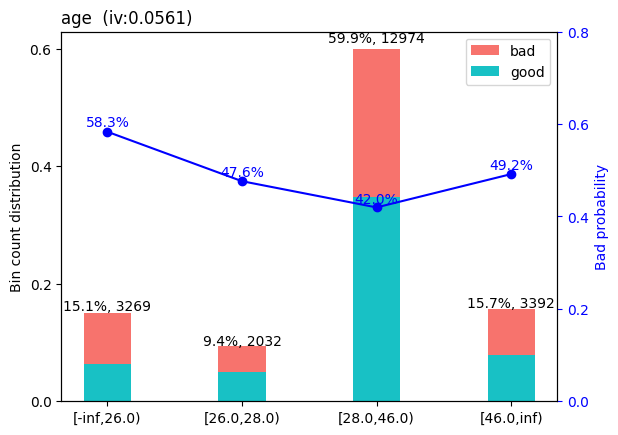

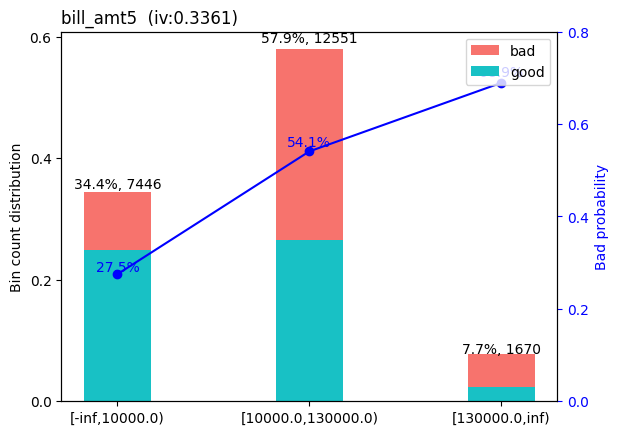

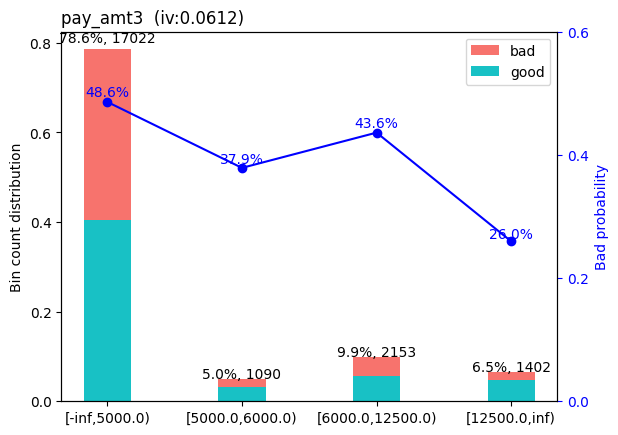

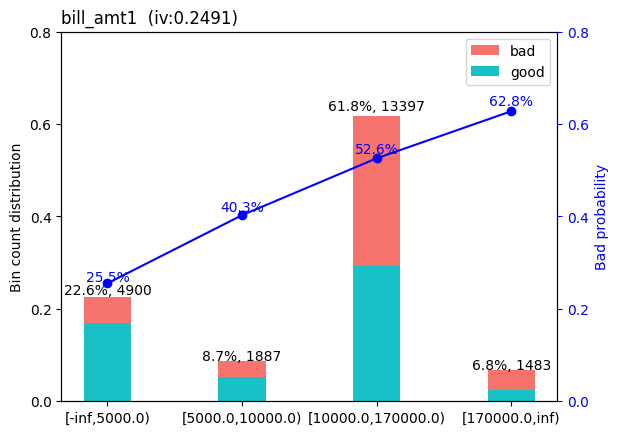

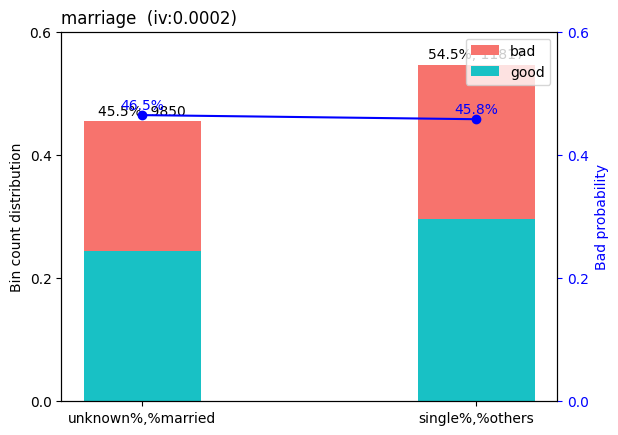

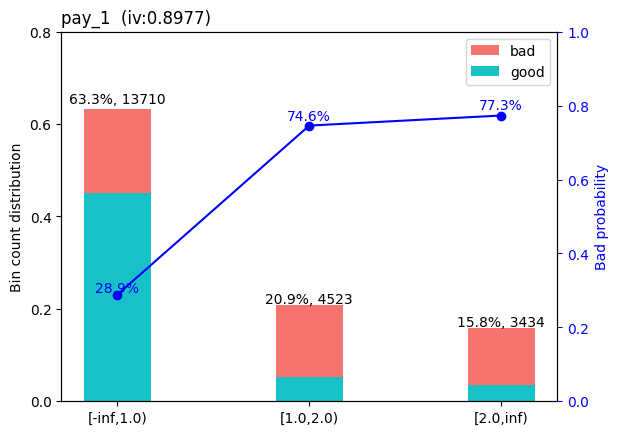

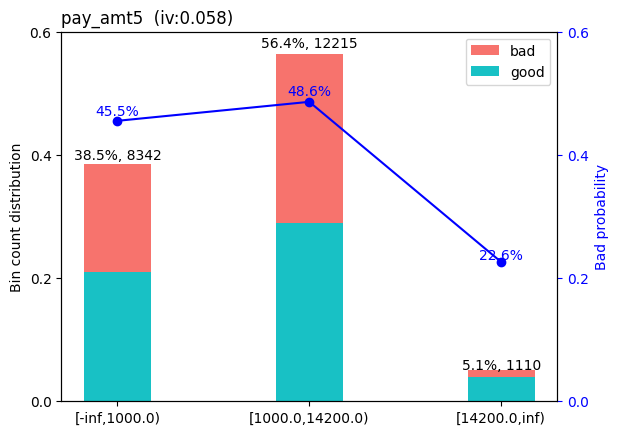

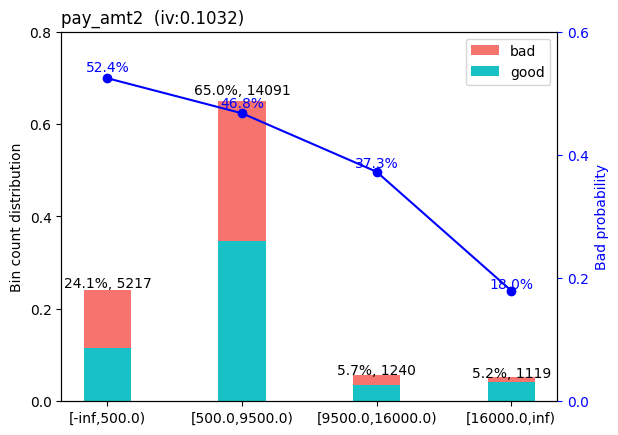

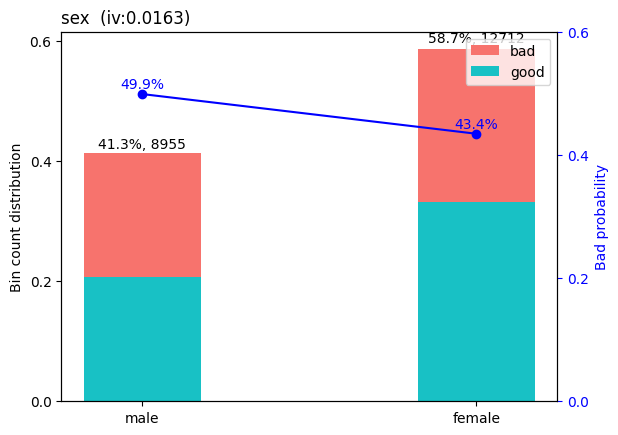

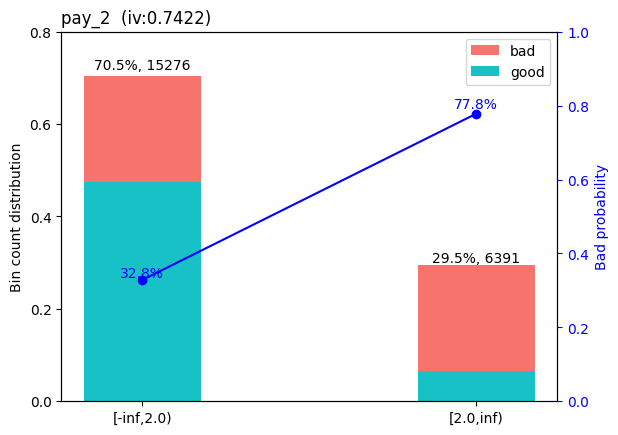

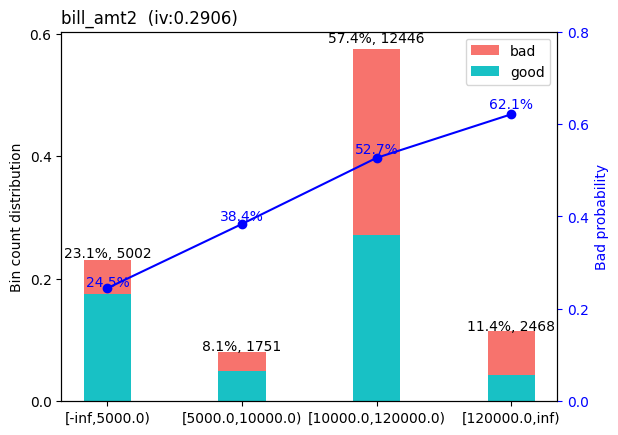

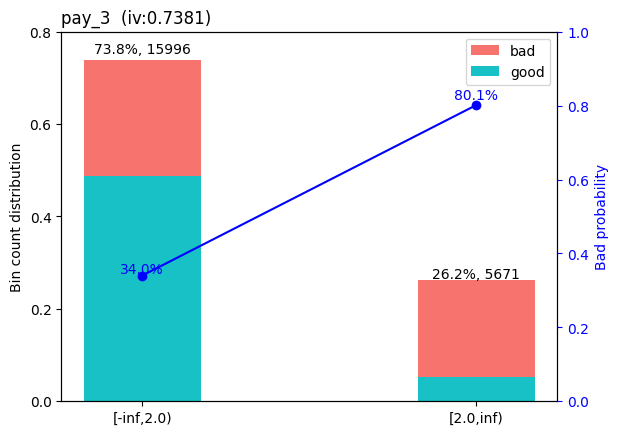

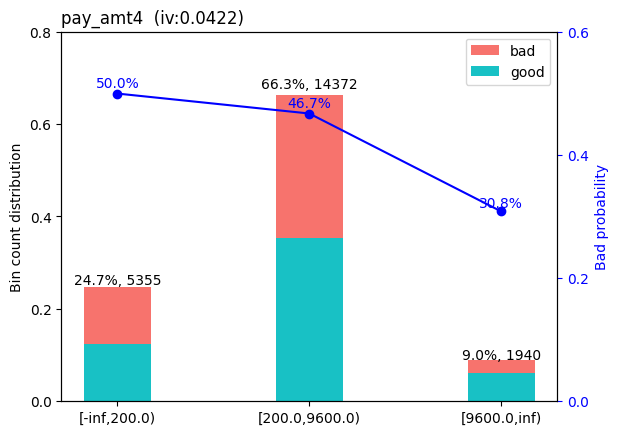

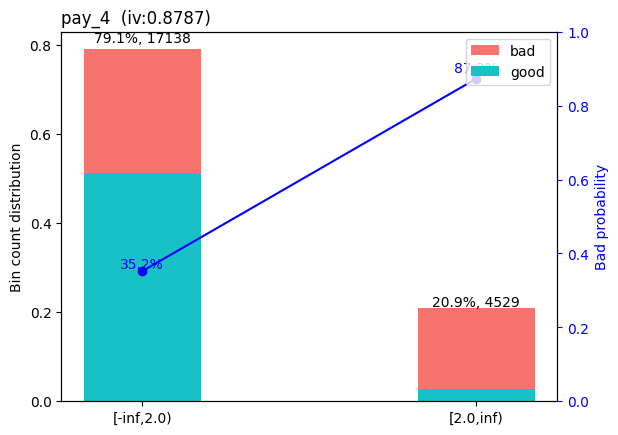

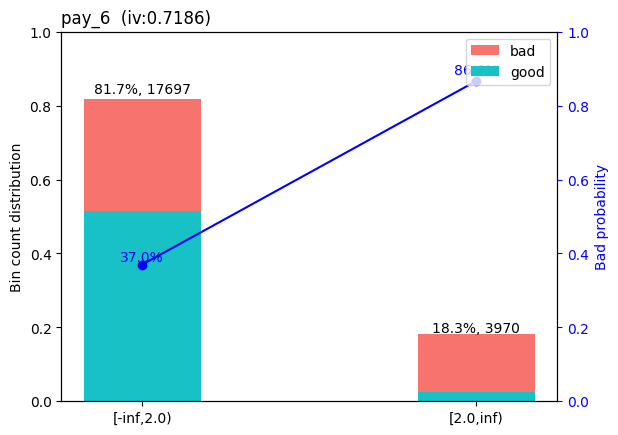

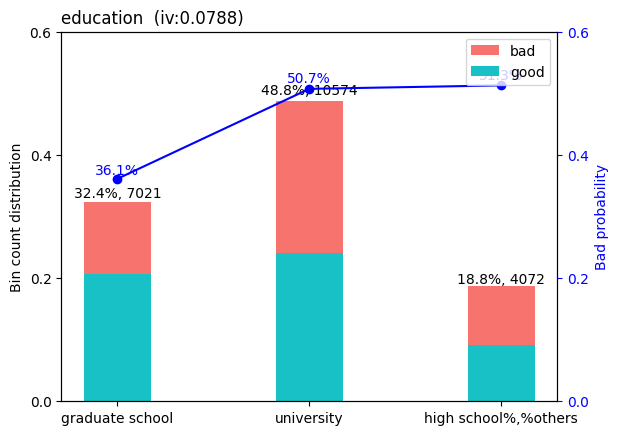

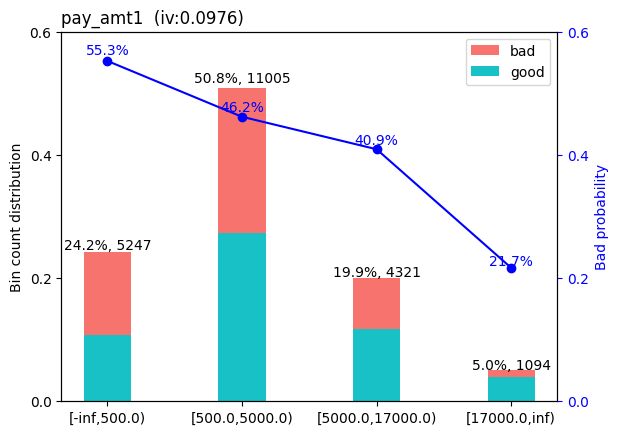

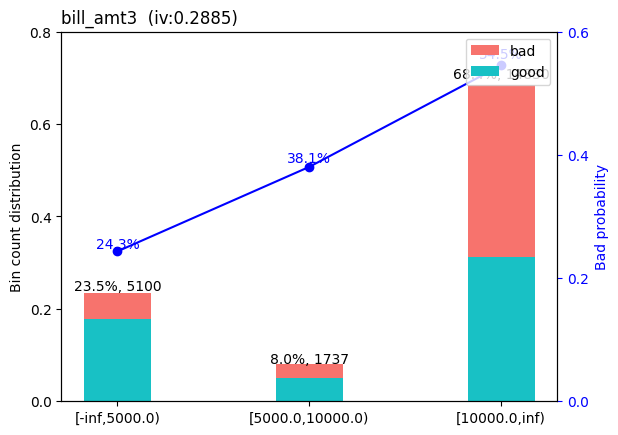

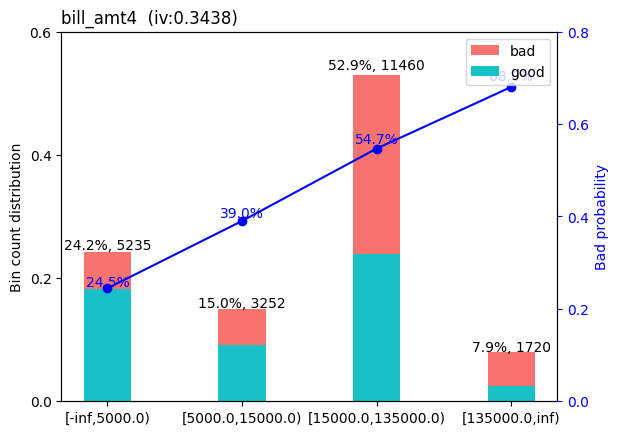

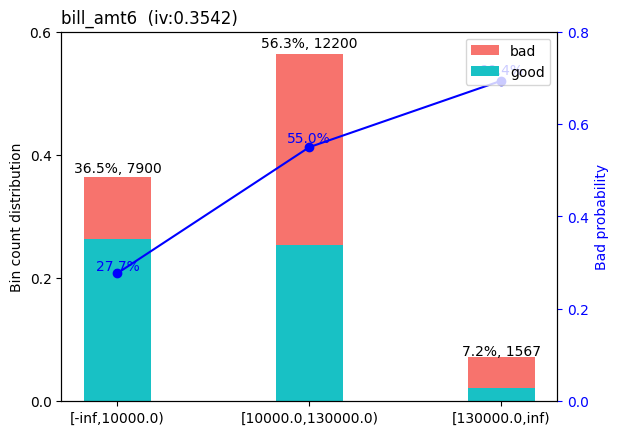

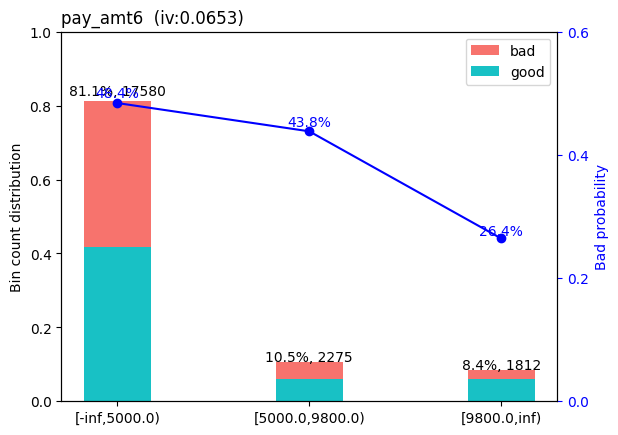

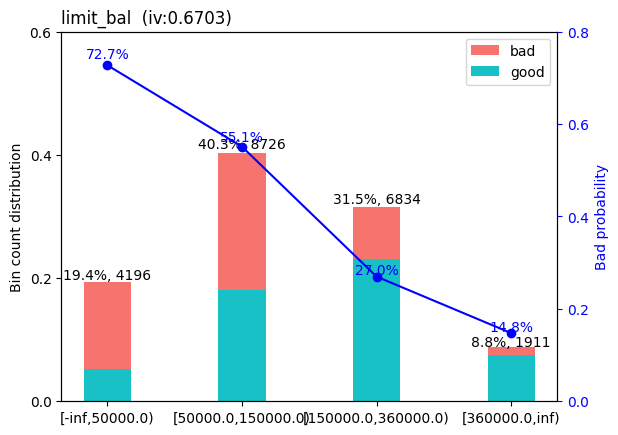

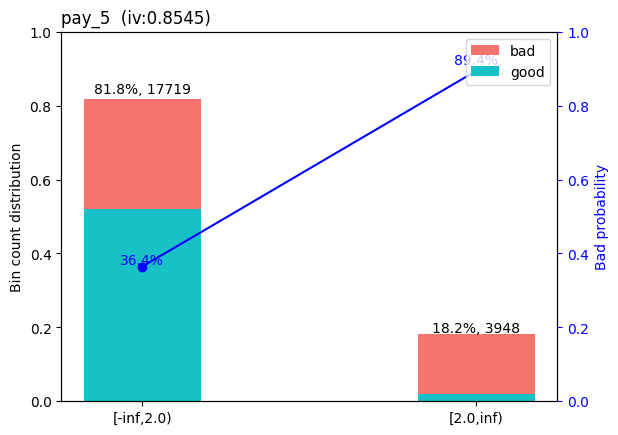

In [38]:
plot_woebin = sc.woebin_plot(bins)

>**Observations**
>
> - Grouped variable `bill_amt4` menunjukan logical linear trend ke atas. Semakin besar `bill_amt4`, maka bad probability akan semakin naik. Artinya, lebih banyak yang default atau gagal bayar pada peningkatan binning.
> - Sama halnya dengan variable `pay_1`, `bill_amt1`, `bill_amt3`, `pay_3`, `pay_6`, `pay_2`, `education`, `bill_amt5`, `bill_amt2`, `pay_5`, `bill_amt6`, `pay_4` yang menunjukan linear trend ke atas.
> - Grouped variable yang menunjukan linear trend turun adalah `pay_amt6`, `sex`, `limit_bal`, `marriage`, `pay_amt2`, dan `pay_amt1`. Artinya lebih sedikit yang gagal bayar pada peningkatan binning. 
> - Meskipun `marriage` dan `sex` ada trendnya, tetapi penurunan tiap bin sangat sedikit. Hal ini mengindikasikan bahwa grouped variable tersebut tidak bisa memisahkan kelas bad dan good secara baik. Ini juga ditandai dari kecilnya nilai Information Value dari masing-masing variable. Decision untuk menghilangkan variable ini pada saat pengecekan Information Value sudah sesuai dengan plot di atas.
> - Grouped variable yang lain, trendnya naik turun. akan lebih baik jika ditinjau secara bisnis.

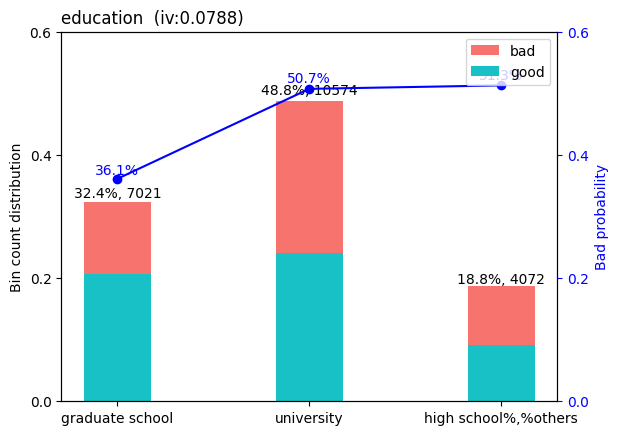

In [39]:
plot_woebin['education']

> Jika kita perhatikan hasil binning default seperti di atas, sepertinya kurang logical trend yang dihasilkan. Urutan pendidikannya juga tidak sesuai dengan jenjang asli [S2, S3] > [S1] > [SMA, dll]. Mari kita coba adjust binningnya.

In [40]:
# binning adjustment
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
breaks_adj = {'education': ['high school', 'university', 'graduate school', 'others']}
bins_adj = sc.woebin(dt=train, 
                     y='gb_flag', 
                     positive=1,
                     breaks_list=breaks_adj)

[INFO] creating woe binning ...


In [41]:
%%capture
plot_woebin = sc.woebin_plot(bins_adj)

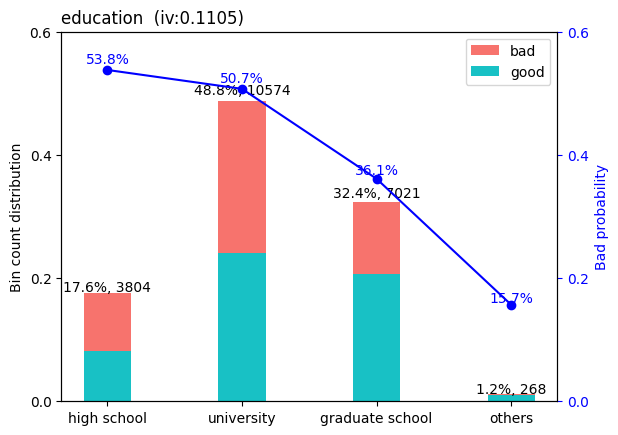

In [42]:
plot_woebin['education']

> **Observation**
>
> Hasil adjustment binning menunjukan tren linear ke bawah. Lebih logical dibanding tren dengan binning sebelumnya.

### Re-adjust dataframe berdasarkan adjustment binning 

In [43]:
# converting train and test into woe values (bins_adj)
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [44]:
# drop columns berdasarkan information variable yang kecil
train_woe.drop(columns=['sex_woe', 'marriage_woe'], inplace=True)
test_woe.drop(columns=['sex_woe', 'marriage_woe'], inplace=True)

In [45]:
# sanity check
print(train_woe.columns.isin(['sex_woe', 'marriage_woe']))
print(test_woe.columns.isin(['sex_woe', 'marriage_woe']))

[False False False False False False False False False False False False
 False False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False]


In [46]:
print('train shape:', train.shape)
print('test shape:', test.shape)
print('train_woe shape:', train_woe.shape)
print('test_woe shape:', test_woe.shape)

train shape: (21667, 24)
test shape: (9285, 24)
train_woe shape: (21667, 22)
test_woe shape: (9285, 22)


# Modeling - Logistic Regression 

Dalam kasus scorecard, beberapa model dapat digunakan untuk memilih set variable yang memiliki kekuatan prediktif paling besar. Model yang biasa digunakan di industri adalah regresi logistik, naive bayes, decision tree, dan neural network.

Secara general, scorecard final yang terbentuk terdiri dari 8 - 15  variabel (Siddiqi, Naeem). Hal ini dilakukan untuk memastikan scorecard yang stabil kekuatan prediksinya, meskipun ada satu - dua variable yang berubah profilnya. Scorecard dengan karakteristik/variable yang terlalu sedikit umumnya tidak mampu bertahan seiring waktu karena rentan terhadap perubahan kecil pada profil pelamar.

Pemodelan akan menggunakan pipeline scikit learn sehingga prediktor dan target perlu dipisahkan untuk penyesuaian input.

In [ ]:
# memisahkan prediktor dan target untuk input model sklearn
y_train = train_woe.loc[:,'gb_flag']
X_train = train_woe.loc[:,train_woe.columns != 'gb_flag']
y_test = test_woe.loc[:,'gb_flag']
X_test = test_woe.loc[:,train_woe.columns != 'gb_flag']

In [ ]:
print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

### `statsmodel` 

In [ ]:
import statsmodels.api as sm

# define variabel prediktor dan target
X = sm.add_constant(X_train)
y = y_train

# fitting model
model_log_1 = sm.Logit(y, X).fit()
print(model_log_1.summary())

🦉 **Interpretasi model:**

- Signifikansi variabel: variabel yang signifikan mempengaruhi target adalah seluruhnya kecuali `pay_amt6_woe`, `bill_amt5_woe`, `age_woe`, `bill_amt1_woe`, `pay_amt4_woe`. Hal ini dilihat dari z-test (P>|z|) yang lebih dari alpha 0.05.

- Signifikasi suatu variabel di atas ditentukan hanya dengan pertimbangan perhitungan statistik dari input data sampel. Pada bagian ini, akan lebih baik jika ditambah dengan perspektif bisnis dan pemilihan variabel tidak mutlak mengikuti hasil statisik saja.  

## Asumsi Model: Multikolinearity

* **Multicollinearity**: antar prediktor tidak saling berkorelasi. Untuk melakukan pengecekannya sama seperti dalam linear regression yaitu menggunakan nilai VIF.

  * -> apabila ada prediktor yang terindikasi multikolinearity, kita bisa menggunakan salah satu variabel saja atau membuat variabel baru yang mensummary dari kedua variabel tersebut (mean)
  * -> dari VIF kita ingin variabel kita memiliki VIF < 10
  
* **Independence of Observations**: antar observasi saling independen & tidak berasal dari pengukuran berulang (repeated measurement).
* **Linearity of Predictor & Log of Odds**: cara interpretasi mengacu pada asumsi ini. untuk variabel numerik, peningkatan 1 nilai akan menaikan log of odds (peluang).

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.api as sm

x = train_woe.drop(columns = 'gb_flag')

xc = sm.add_constant(x)
vif = [vif(xc.values, i) for i in range(len(xc.columns))]
pd.Series(data=vif, index = xc.columns).sort_values(ascending=False)

> Tidak ada variabel prediktor yang saling berkorelasi.

Jika terjadi multicollinearity, yang dapat dilakukan adalah:

- Membuang salah satu variabel
- Membuat variabel baru, dari rata-rata nilai kedua variabel

> Ketika nilai VIF > 10 maka **ada hubungan yang kuat antar prediktor**. Yang diingkan ketika membuat model, nilai VIF < 10 agar **tidak ada hubungan antar prediktor**.

# Predict 

In [ ]:
# code of predict value from model
test_woe['pred_risk'] = model_log_1.predict(sm.add_constant(X_test))
test_woe['pred_risk'].head()

📝 Notes: Fungsi predict untuk model logistik regresi akan mengembalikan hasil prediksi dalam bentuk **probability**

Hasil prediksi yang dikeluarkan masih berupa probability dengan range 0-1. Untuk dapat mengubah nilai probability tersebut, kita bisa menetapkan threshold pada probability untuk masuk ke kelas 1 atau 0. Umumnya threshold yang digunakan yaitu 0.5. 

🔻 Menggunakan fungsi `apply(lambda x: True if x > thres else 0)`

In [ ]:
# change probability to predict class
test_woe['pred_label'] = test_woe['pred_risk'].apply(lambda x: 1 if x > 0.5 else 0)
test_woe['pred_label'].head()

# Evaluation Model 

## Accuracy, Precision, Recall

Setelah prediksi menggunakan model, kita dapat mengevaluasi hasi prediksi dengan membandingkan dengan label data asli. Pada kasus klasifikasi, hal tersebut  berdasarkan confusion matrix:

- Penentuan kelas:
  + kelas positif: kelas yang lebih difokuskan 
  + kelas negatif: kelas yang tidak difokuskan
 

- Isi dari Confusion Matrix:

  * *True Positive (TP)*: diprediksi positif dan benar (prediksi positif; aktual positif)
    - Aktualnya: Gagal Bayar
    - Prediksinya: Gagal Bayar
  * *True Negative (TN)*: diprediksi negatif dan benar (prediksi negatif; aktual negatif) 
    - Aktualnya: Bisa Bayar
    - Prediksinya: Bisa Bayar
  * *False Positive (FP)*: diprediksi positif namun salah (prediksi positif; aktual negatif)
    - Aktualnya: Bisa bayar
    - Prediksinya: Tidak bisa bayar
  * *False Negative (FN)*: diprediksi negatif namun salah (prediksi negatif; aktual positif)
    - Aktualnya: Gagal Bayar
    - Prediksinya: Bisa Bayar
    
![](assets/tnfp.PNG)

In [ ]:
# membandingkan hasil prediksi dengan data actual
pd.crosstab(test_woe['pred_label'], test_woe['gb_flag'])

In [ ]:
from sklearn import metrics

# Calculate accuracy
accuracy_lr = metrics.accuracy_score(test_woe['gb_flag'], test_woe['pred_label'])
print('accuracy:', accuracy_lr)

In [ ]:
from sklearn.metrics import classification_report

pred_risk = model_log_1.predict(sm.add_constant(X_train))
pred_label = pred_risk.apply(lambda x: 1 if x > 0.5 else 0)
print(classification_report(y_true = train_woe['gb_flag'],
                            y_pred = pred_label,
                            target_names = ['non-default/0', 'default/1'],
                            digits = 3))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test_woe['gb_flag'],
                            y_pred = test_woe['pred_label'],
                            target_names = ['non-default/0', 'default/1'],
                            digits = 3))

### ROC and AUC 

Selain menggunakan confusion matrix, cara evaluasi lainnya yang dapat kita gunakan adalah menggunakan kurva ROC & AUC. 

**Receiver-Operating Curve (ROC)** adalah kurva yang menggambarkan nilai *True Positive Rate* dan *False Positive Rate* pada setiap kemungkinan threshold. **Area Under Curve (AUC)** adalah area di bawah kurva ROC.

$TPR  / Recall = \frac{TP}{TP +FN}$

- 🔎 Seberapa banyak yang **benar diprediksi positif**, dari yang **re**ality-nya positif. 

$FPR= \frac {FP}{FP +TN}$

- 🔎 Seberapa banyak yang **salah diprediksi positif**, dari yang **re**ality-nya negatif. 

Karakteristik ROC curve:

- Kurva yang baik adalah kurva yang mendekati L terbalik di pojok kiri atas (persegi) (TPR = 1, FPR = 0).

AUC adalah Area under curve atau luas dibawah kurva ROC. Jika nilai AUC semakin mendekati nilai 1, model semakin baik dalam memisahkan kelas positif dan negatif.

- AUC = 1, model memiliki performa ideal
- AUC = 0.5, model tidak lebih baik dalam memprediksi dibandingkan kalau kita menebak secara acak

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

roc_auc_train = roc_auc_score(y_train,model_log_1.predict(sm.add_constant(X_train)))
fpr, tpr, threshold = roc_curve(pd.to_numeric(y_train),model_log_1.predict(sm.add_constant(X_train)))
roc_auc = auc(fpr,tpr)
print("AUC pada data train:", roc_auc_train)

In [ ]:
plt.figure()
plt.plot(fpr,tpr,color ='blue',label='ROC curve(area= %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic : Train Data")
plt.legend(loc='lower right')
plt.show()

In [ ]:
roc_auc_test = roc_auc_score(y_test,model_log_1.predict(sm.add_constant(X_test)))
fpr, tpr, threshold = roc_curve(pd.to_numeric(y_test),model_log_1.predict(sm.add_constant(X_test)))
roc_auc = auc(fpr,tpr)
print("AUC pada data test:", roc_auc_test)

In [ ]:
plt.figure()
plt.plot(fpr,tpr,color ='blue',label='ROC curve(area= %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic : Test Data")
plt.legend(loc='lower right')
plt.show()

> Interpretasi:
>
> - Model mampu memprediksi default (1) atau not default (0) dari yang AKTUAL nya negatif dan positif.
> - Nilai ROC sebesar 0.88 atau 88% artinya model dikatakan memiliki nilai AUC yang cukup baik.

### Kolmogorov-Smirnov (KS) Statistic 

KS (Kolmogorov-Smirnov) Statistics adalah salah satu metode statistik yang sering digunakan untuk membandingkan distribusi skor antara dua kelompok, misalnya dalam analisis kinerja credit model (membedakan antara good dan bad customers).

Nilai KS yang tinggi menunjukkan model yang baik dalam membedakan antara kedua kelompok (misalnya, good vs bad customers). 

> Biasanya, nilai KS > 0.4 dianggap baik dalam kredit scoring.

In [ ]:
# performance ks & roc ------
train_prob = model_log_1.predict(sm.add_constant(X_train))
train_perf = sc.perf_eva(y_train, train_prob, title = "train")
test_perf = sc.perf_eva(y_test, test_woe['pred_risk'], title = "test")

# Scorecard 

Pada model logistic regression, output yang dihasilkan berupa prediksi apakah default atau tidak default dalam bentuk probabilitas atau label kelas. 

Untuk mempermudah pengambilan keputusan apakah seorang debitur akan default dan tidak default maka hasil binning dapat dibuat menjadi penilaian dalam bentuk **score point** untuk **setiap bin** yang diakumulasikan menjadi **scorecard**.

Manfaat pembentukan scorecard antara lain:

- **Pengambilan keputusan yang konsisten**: Hal ini mengurangi tingkat subjektivitas dalam proses pengambilan keputusan dan memberikan dasar yang lebih objektif untuk menilai kredit.
- **Penilaian risiko individu**: Scorecard membantu memberikan gambaran tentang seberapa besar risiko default yang dimiliki oleh debitur berdasarkan karakteristik peminjam.
- **Pengelolaan risiko lebih baik**: Dengan scorecard dapat mengidentifikasi risiko, dan menentukan keketatan risiko berdasarkan pemahaman yang lebih mendalam tentang profil risiko debitur.

Rumus umum pembentukan score dalam setiap binning (Siddiqi, Naeem):

$$
Points_{ij} = (\frac{pdo}{ln(2)}) \times -Coef_i \times WOE_{ij}
$$

Keterangan:

- `Coef`  : Hasil nilai coefficient dari logistic regression
- `WOE`   : Nilai WOE dari setiap binning untuk setiap variabelnya

📌 Untuk membuat `scorecard` dapat menggunakan fungsi `scorecard()` dengan parameter:

- `bins`: object binning hasil `woebin()`
- `model`: object model hasil `glm()`
- `odds0`: **Tingkat keketatan** / target odds, rasio kemungkinan default terhadap kemungkinan tidak default. Contoh: 1/19, artinya 1 yg akan default dibanding 19 yang tidak default. Semakin kecil, semakin ketat (ditentukan oleh user)
- `points0`: **Target points** ketika `odds0` tercapai. Contoh: points0 = 600 dan odds0 = 1/19, maka pada poin 600 berarti terdapat 1 debitur default terhadap 19 debitur lain yang tidak default (ditentukan oleh user)
- `pdo`: **points to double the odds**, ketika skor kredit suatu individu naik sebesar PDO, itu mengindikasikan bahwa **peluang (odds) untuk individu itu berhasil bayar** mengalami perubahan sebanyak **dua kali lipat**. Sebaliknya, jika skor kredit turun sebesar PDO, peluangnya mengalami penurunan setengahnya (ditentukan oleh user).

❓ Contoh kasus:

Ingin dihasilkan sebuah scorecard sesuai dengan kebutuhan user dengan odds 19:1 pada poin 600 dan ingin peluangnya berlipat ganda setiap kenaikan 20 poin, maka bagaimana pembentukan scorecardnya?

In [ ]:
score_card = sc.scorecard(bins=bins_adj,
                        model=model_log_1, # Model terbaik
                        xcolumns=X_train.columns)
score_card

# References

- [Siddiqi, Naeem. (2006). Credit risk scorecards : developing and implementing intelligent credit scoring by Naeem Siddqi . New Jersey: John Wiley & Sons.](https://students.aiu.edu/submissions/profiles/resources/onlineBook/b9m4e7_Credit_Risk%20Scorecards%20Developing%20finance.pdf)
- [scorecardpy library](https://pypi.org/project/scorecardpy/)